# WiFi Channel State Information (CSI) example

Necessary imports.

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import re

Put a `csi.json` file in the `data` directory and specify the `file_name` variable.

In [17]:
file_name = "Rp01_Ac6_Vhigh_Ar1_UNC187_Rxall_csi.json"

# extracting information from the filename
match = re.search(pattern=r"Rp(\d+)_Ac(\d)_V(\w+)_Ar(\d)_UNC(\d+)", string=file_name)
if match == None:
    raise Exception("The filename does not match the standard!")

repetition = int(match[1])
action = int(match[2])
velocity = match[3]
robotic_arm = int(match[4])
motion_uncertainty = int(match[5])/100

print("Extracted information from the filename")
print(f"  - repetition          : {repetition}")
print(f"  - action              : {action}")
print(f"  - velocity            : {velocity}")
print(f"  - robotic arm         : {robotic_arm}")
print(f"  - motion uncertainty  : {motion_uncertainty}")

Extracted information from the filename
  - repetition          : 1
  - action              : 6
  - velocity            : high
  - robotic arm         : 1
  - motion uncertainty  : 1.87


Reading the `csi.json` file.

In [18]:
module_numbers = []       # storing the module numbers
csi_amplitudes = {}       # dictionary to map the module number to its corresponding CSI matrix 
timestamps = {}           # dictionary to map the module number to its corresponding time stamps [second]
RSS = {}                  # dictionary to map the module number to its corresponding Received Signal Strength (RSS)

with open(os.path.join("data", file_name), 'r') as f:
    json_data = json.load(f)
    for module_data in json_data:
        module_number = module_data["module_number"]
        module_numbers.append(module_number)
        
        RSS[module_number] = module_data["RSS"]
        timestamps[module_number] = np.array(module_data["time_stamp_ns"])/1.e9
        
        csi_str = module_data['complex_csi'] # the complex numbers are stored as strings in the json file
        csi_complex = np.array([[complex(num) for num in row] for row in csi_str]) # converting string complex numbers to complex numpy array
        csi_amplitudes[module_number] = abs(csi_complex) # keeping the amplitudes

module_numbers = sorted(module_numbers)


Plotting the CSI amplitude matrix for each module.

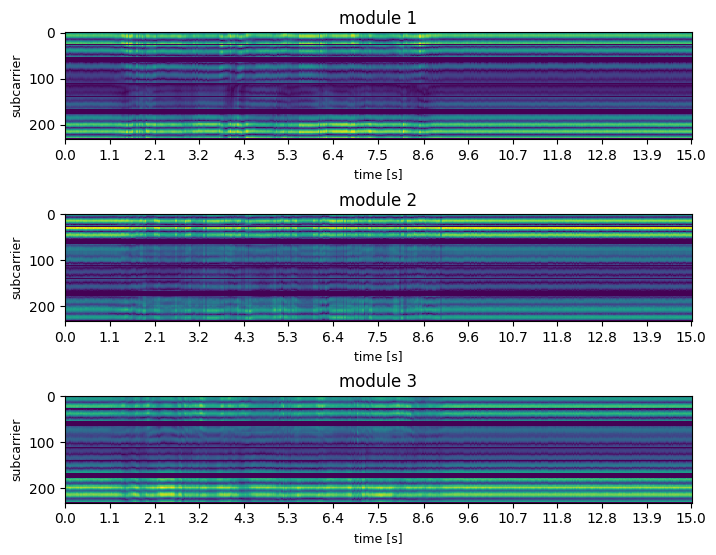

In [19]:
fig, axes = plt.subplots(nrows=len(module_numbers), ncols=1)
if len(module_numbers) == 1:
    axes = [axes]

for ax_cnt, module_number in enumerate(module_numbers):
    ax = axes[ax_cnt]
    
    csi_amp_ = csi_amplitudes[module_number]
    timestamps_ = timestamps[module_number]
    
    num_of_subcarriers = csi_amp_.shape[1]
    if num_of_subcarriers == 256: # 80 Mhz collection
        csi_amp_ = np.delete(csi_amp_, [0, 1, 2, 3, 4, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 253, 254, 255], axis=1) # pilot and unused subcarriers

    # constructing labels and the x axis to represent time in seconds
    label_places = np.round(np.linspace(0, len(timestamps_) - 1, 15)).astype(int)
    ax.set_xticks(label_places, np.round(timestamps_[label_places], 1), rotation='horizontal', fontsize=10, fontweight='regular')
    
    ax.imshow(csi_amp_.T, interpolation="nearest", aspect="auto")
    
    ax.set_title(f"module {module_number}")
    ax.set_xlabel("time [s]", fontsize=9, fontweight='regular')
    ax.set_ylabel("subcarrier", fontsize=9, fontweight='regular')

plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.1, hspace=0.7)

Plotting the RSS values for each module.

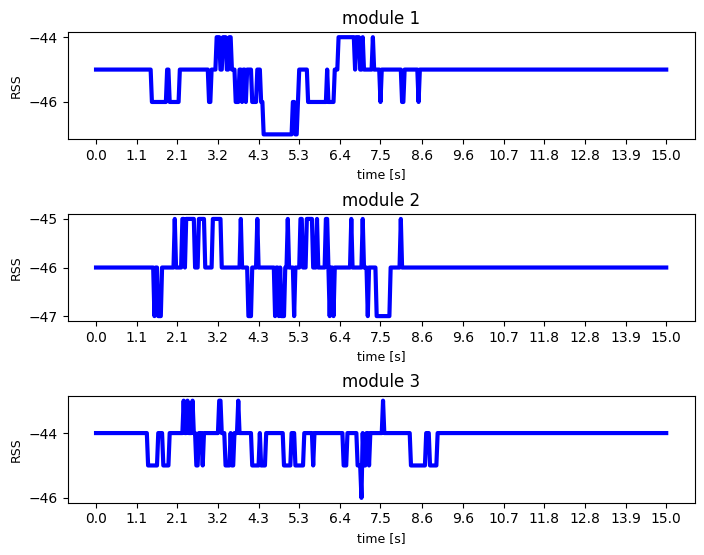

In [20]:
fig, axes = plt.subplots(nrows=len(module_numbers), ncols=1)
if len(module_numbers) == 1:
    axes = [axes]

for ax_cnt, module_number in enumerate(module_numbers):
    ax = axes[ax_cnt]
    
    rss_ = RSS[module_number]
    timestamps_ = timestamps[module_number]

    # constructing labels and the x axis to represent time in seconds
    label_places = np.round(np.linspace(0, len(timestamps_) - 1, 15)).astype(int)
    ax.set_xticks(label_places, np.round(timestamps_[label_places], 1), rotation='horizontal', fontsize=10, fontweight='regular')
    
    ax.plot(rss_, color='blue', linestyle='solid', linewidth=3)
    
    ax.set_title(f"module {module_number}")
    ax.set_xlabel("time [s]", fontsize=9, fontweight='regular')
    ax.set_ylabel("RSS", fontsize=9, fontweight='regular')

plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.1, hspace=0.7)